In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [3]:
pip install lmdb

Note: you may need to restart the kernel to use updated packages.


In [4]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


In [29]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


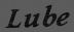

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


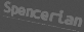

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


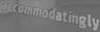

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


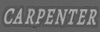

In [40]:
# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        
        label_key = 'label-%09d'.encode() % index # 문자열 포멧팅 : 바이트 문자열 변환 - 
        # -%09d : 숫자 포멧팅 - d : integer, %09 : 숫자를 최소 "9자리로 표현하되, 자리수 부족 시 0을 채워라."
        # 결과 : label-00000000i (i : index) : unicode로 직접 호출은 안됨. encode를 통한 바이트로 호출해야 함

        label = txn.get(label_key).decode('utf-8') # 위 결과에 대한 decode시 키-벨류 쌍에 해당?
        
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key) # unicode의 형태로 이미지를 불러옵니다. 

        buf = six.BytesIO() # BytesIO를 통해서 버퍼로 변환
        buf.write(imgbuf) # 이미지 데이터를 버퍼(buf)에 쓰기
        buf.seek(0) # 버퍼의 포인터를 처음으로 이동(향후 읽기 위해서)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB') # 읽기 시도 및 버퍼를 이미지로 변환

        except IOError:
            img = Image.new('RGB', (100, 32)) # 예외 발생 시, 빈 RGB 이미지를 생성
            label = '-' # Dummy 레이블 설정

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        
#         print(img) # width x 32의 형태
        
        # 크기를 변환하고 RGB 채널을 변환
        img = np.array(img.resize(target_img_size) # (width, height), PIL.Image.resize의 구현이슈
                      ).transpose(1,0,2)
        
#         print(img.dtype) # uint8

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        
        display(Image.fromarray(img.transpose(1,0,2
                                             )
#                                 .astype(np.uint8) # 이미 uint8이라서 해당 코드에서는 영향이 없다.
                               ))

In [32]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100
        
        # num_sample, index_list를 얻기 위해서 임시로 env열기
        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        
        # 1. 배치 인덱스 계산 및 데이터의 인덱스 가져오기
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ] # batch 내에 개별 인덱스를 저장
        
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2. 배치 배열로 이미지와 레이블을 저장
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img # width만큼 잘라서 저장
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3. 딕셔너리로 구성하여 데이터 셋 반환
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])} # Dummy

        return inputs, outputs

print("슝~")

슝~


In [21]:

class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character # 0은 '-'에 해당 
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label: 
            decoded_label += self.character[encode]
        return decoded_label

In [22]:
label_converter = LabelConverter(TARGET_CHARACTERS) # 숫자, 영대문자를 포함한 String을 인자로 삽입

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [10]:
# CTC : Connectionist Temporal Classification
# 입/출력의 시퀀스 길이가 다를 때 (주로 입력이 클때), "정렬이 명시되지 않은 상태"에서 학습이 가능
# 시퀀스예측 - 음성인식과 OCR분야에서 사용
# 

def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :] # 첫 두 타임스텝을 제외하여 사용 (특정 부분만 사용)
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


In [11]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)

    # RNN 부분
    sequnce = layers.Reshape(target_shape=(24, 512))(feature) # feature to sequence
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    # 분류기의 최종 예측
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("슝~")

슝~


In [41]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, 
                              label_converter, 
                              batch_size=BATCH_SIZE, 
                              character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, 
                            label_converter, 
                            batch_size=BATCH_SIZE, 
                            character=TARGET_CHARACTERS)
model = build_crnn_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 50, 16, 64)   0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 50, 16, 128)  73856       max_pooling2d_8[0][0]            
____________________________________________________________________________________________

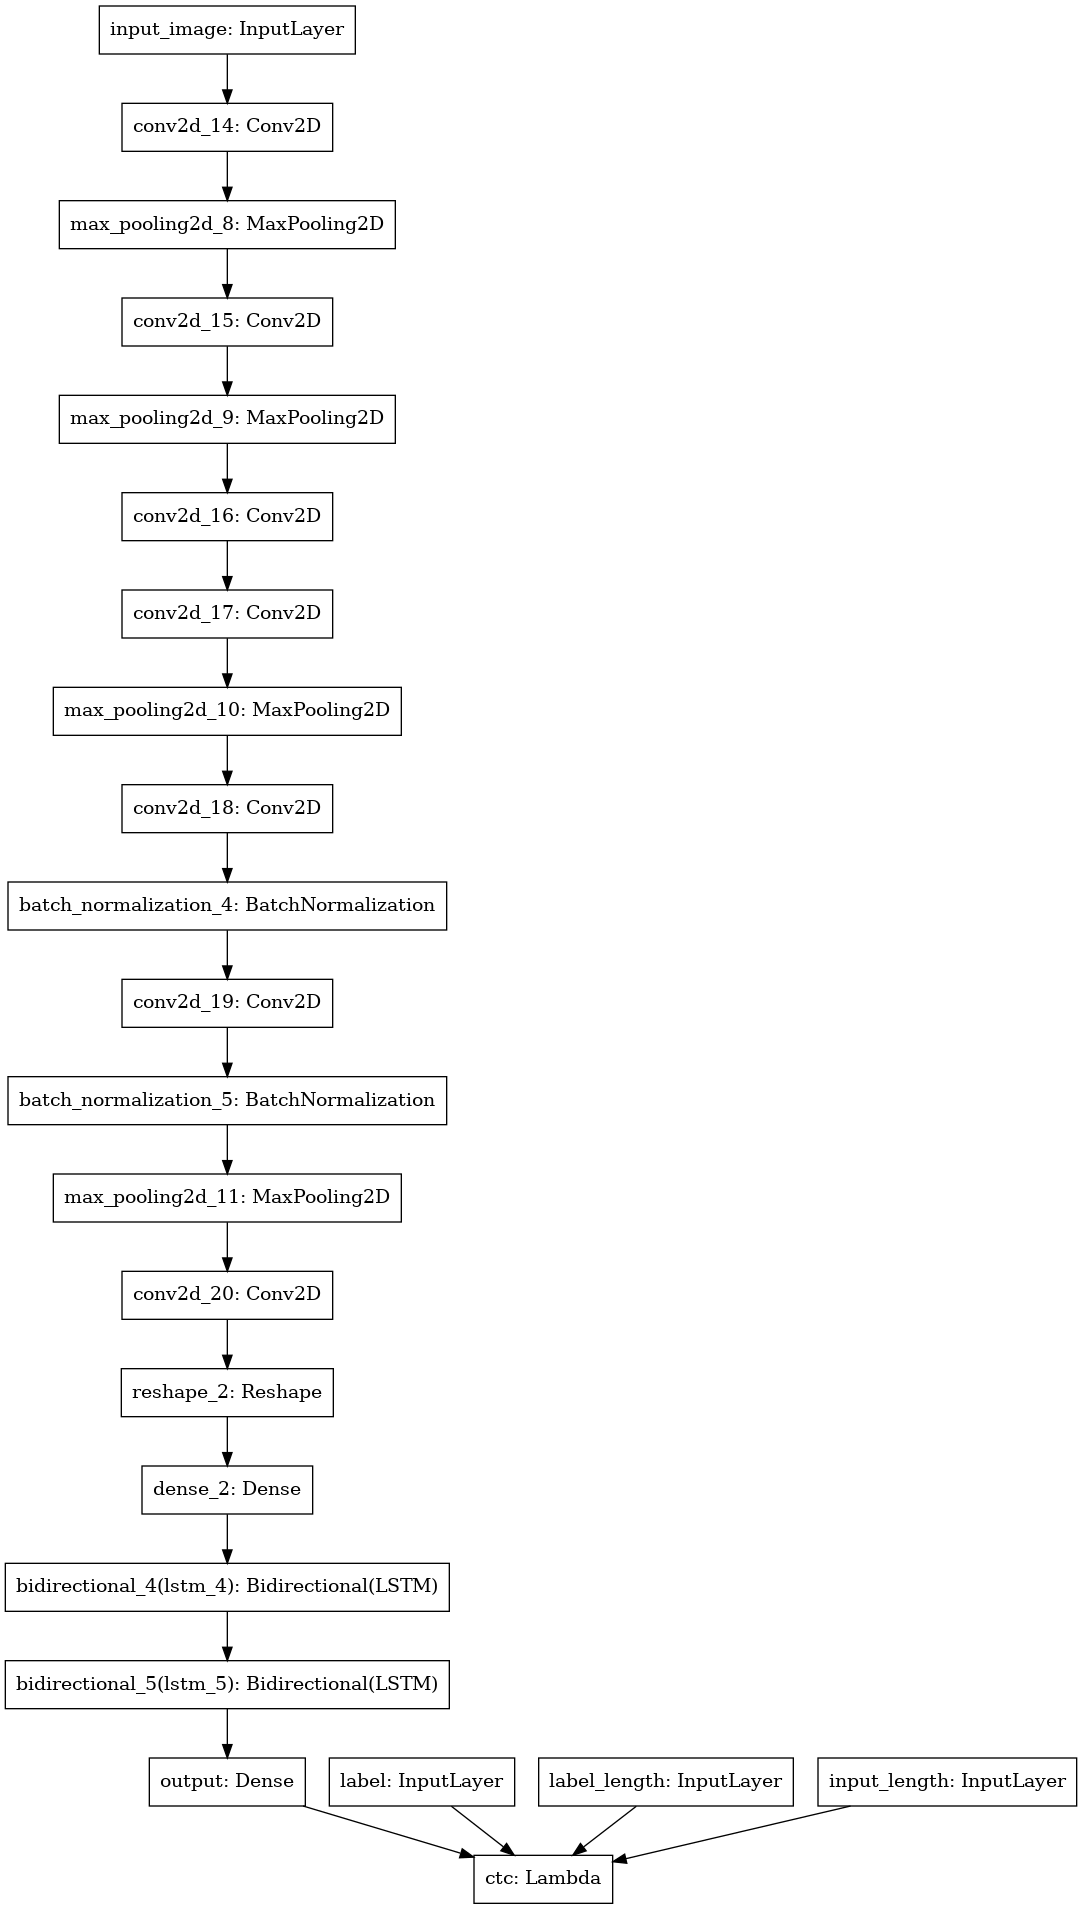

In [44]:
tf.keras.utils.plot_model(model)

In [54]:
# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, 
              optimizer=optimizer,
             metrics=['accuracy'])
'''
여기서 loss 인자는 손실 함수를 지정
{'ctc': lambda y_true, y_pred: y_pred}는 
모델의 출력이 'ctc'일 때, 손실 함수로 lambda y_true, y_pred: y_pred를 사용하라는 뜻
람다 함수는 실제로는 아무 계산도 하지 않고 y_pred를 반환. 
이는 y_pred가 이미 Lambda 레이어에서 CTC 손실로 계산된 값이기 때문이다. 
''' 

"\n여기서 loss 인자는 손실 함수를 지정\n{'ctc': lambda y_true, y_pred: y_pred}는 \n모델의 출력이 'ctc'일 때, 손실 함수로 lambda y_true, y_pred: y_pred를 사용하라는 뜻\n람다 함수는 실제로는 아무 계산도 하지 않고 y_pred를 반환. \n이는 y_pred가 이미 Lambda 레이어에서 CTC 손실로 계산된 값이기 때문이다. \n"

In [55]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
# ModelCheckPoint의 경우 'val_loss'를 모니터링하고 weight만 저장하는 옵션으로 지정해주세요.
# EarlyStopping도 'val_loss'를 모니터링해주세요.
# (EarlyStopping을 사용하지 않는 경우, model.fit()의 epoch 옵션을 20 정도로 설정해주세요.

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

ckp = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                         monitor='val_loss', save_best_only=True, 
                                         save_weights_only=True)

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=5, restore_best_weights=True)


history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          # ModelCheckPoint와 EarlyStopping을 활용하는 경우 바로 아래 callbacks 옵션에 주석을 풀어주세요.
          callbacks=[ckp, earlystop]
)

Epoch 1/20
565/565 [==============================] - 90s 149ms/step - loss: 1.7861 - accuracy: 0.6465 - val_loss: 4.2321 - val_accuracy: 0.5019
Epoch 2/20
565/565 [==============================] - 82s 145ms/step - loss: 1.3917 - accuracy: 0.7021 - val_loss: 4.2777 - val_accuracy: 0.5324
Epoch 3/20
565/565 [==============================] - 82s 145ms/step - loss: 1.1060 - accuracy: 0.7432 - val_loss: 4.4051 - val_accuracy: 0.5388
Epoch 4/20
565/565 [==============================] - 82s 145ms/step - loss: 0.8859 - accuracy: 0.7800 - val_loss: 4.7311 - val_accuracy: 0.5340
Epoch 5/20
565/565 [==============================] - 82s 145ms/step - loss: 0.7101 - accuracy: 0.8113 - val_loss: 4.8199 - val_accuracy: 0.5418
Epoch 6/20
565/565 [==============================] - 82s 145ms/step - loss: 0.5767 - accuracy: 0.8339 - val_loss: 5.1723 - val_accuracy: 0.5470


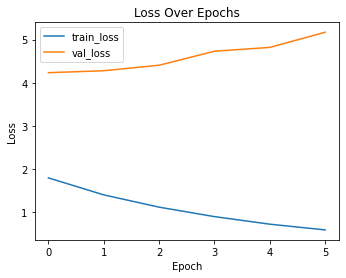

In [69]:
import matplotlib.pyplot as plt

def plot_history(history):
    # 학습과 검증 손실
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

#     # 학습과 검증 정확도
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history.get('accuracy', []), label='train_accuracy')
#     plt.plot(history.history.get('val_accuracy', []), label='val_accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.title('Accuracy Over Epochs')

    plt.show()

# 시각화 함수 호출
plot_history(history)

Accuracy의 경우 CTC에서는 쓰지 않는것이 좋다고 한다.
굳이 쓸거라면 CTC이후 디코딩 후의 결과에 대한 매칭여부로 구현해야 한다.

In [70]:
def train_model(lr=1e-1, epochs=20, batch_size=BATCH_SIZE):
    
    train_set = MJDatasetSequence(TRAIN_DATA_PATH, 
                              label_converter, 
                              batch_size=batch_size, 
                              character=TARGET_CHARACTERS, is_train=True)
    val_set = MJDatasetSequence(VALID_DATA_PATH, 
                            label_converter, 
                            batch_size=batch_size, 
                            character=TARGET_CHARACTERS)
    
    model=build_crnn_model()
    
    checkpoint_path = HOME_DIR + f'/model_checkpoint_{lr}_{epochs}.hdf5'
    optimizer = tf.keras.optimizers.Adadelta(lr=lr, clipnorm=5)

    ckp = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                             monitor='val_loss', save_best_only=True, 
                                             save_weights_only=True)

    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 patience=5, restore_best_weights=True)


    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, 
              optimizer=optimizer,
#              metrics=['accuracy']
                 )

    history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          # ModelCheckPoint와 EarlyStopping을 활용하는 경우 바로 아래 callbacks 옵션에 주석을 풀어주세요.
          callbacks=[ckp, earlystop])
    
    plot_history(history)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
283/283 [==============================] - 87s 288ms/step - loss: 26.7038 - val_loss: 27.9842
Epoch 2/20
283/283 [==============================] - 80s 283ms/step - loss: 23.6877 - val_loss: 22.7404
Epoch 3/20
283/283 [==============================] - 80s 283ms/step - loss: 16.3441 - val_loss: 12.9703
Epoch 4/20
283/283 [==============================] - 80s 283ms/step - loss: 9.1002 - val_loss: 8.5337
Epoch 5/20
283/283 [==============================] - 80s 282ms/step - loss: 6.5208 - val_loss: 6.7508
Epoch 6/20
283/283 [==============================] - 80s 283ms/step - loss: 5.1679 - val_loss: 5.5716
Epoch 7/20
283/283 [==============================] - 80s 282ms/step - loss: 4.2922 - val_loss: 5.2118
Epoch 8/20
283/283 [==============================] - 80s 284ms/step - loss: 3.6318 - val_loss: 4.7873
Epoch 9/20
283/283 [==============================] - 80s 282ms/step - loss: 3.0938 - val_loss: 4.6282
Epoch 10/20
283/283 [==============================] - 80s 283ms/st

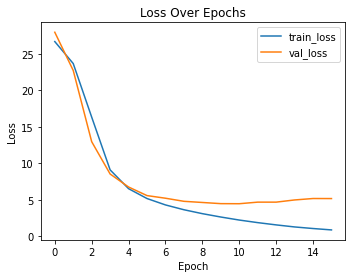

In [71]:
train_model(epochs=20, batch_size=256)

In [73]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/model_checkpoint_0.1_20.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, 
                             label_converter, batch_size=BATCH_SIZE, 
                             character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 

# 입, 출력 레이어를 뽑아서 Model을 다시 정의
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


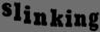

Result: 	 ALEPPO99999999999999999


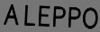

Result: 	 RWENDA999999999999999999


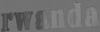

Result: 	 NATHANS99999999999999999


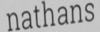

Result: 	 HALP99999999999999999999


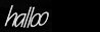

Result: 	 HURLS9999999999999999999


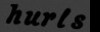

Result: 	 DOWNSIZE9999999999999999


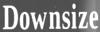

Result: 	 ROBOTIC99999999999999999


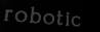

Result: 	 SLOPPY99999999999999999


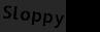

Result: 	 HERMITE99999999999999999


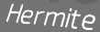

In [74]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

- 눈대중으로 봤을 때, 정확도가 85% 이상은 나오는 것으로 판단된다! Project에 사용하도록 하겠다.